# Sentiment Analytics on Twitter Tweets

## Import Dependencies

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

In [68]:
df_pos = pd.read_csv('Dataset/positive_keyword_part1_revisi.csv')
df_pos['Sentimen'] = 'positive'
df_pos.head()

,text,keyword,Sentimen
0,Jam 8 alhamdulillah,alhamdulillah,positive
1,Alhamdulillah naik terus skrg dah lulus,alhamdulillah,positive
2,Alhamdulillah,alhamdulillah,positive
3,"Alhamdulillah, kenyang, kupat tahu nya banyak ...",alhamdulillah,positive
4,"Ada pepatah Greek mengatakan, “whom the gods l...",alhamdulillah,positive


In [69]:
df_neg = pd.read_csv('Dataset/negative_keyword_part1_revisi.csv')
df_neg['Sentimen'] = 'negative'
df_neg.head()

,text,keyword,Sentimen
0,Chenle itu lumba lumba bukan hiu kampret,kampret,negative
1,@Fitokimiaa kampret dah,kampret,negative
2,U kno kampret,kampret,negative
3,Ada woe kampret kali dibilang penyakit :/,kampret,negative
4,"Emang janji tinggal janji, ketika liat duit, A...",kampret,negative


In [70]:
df = pd.concat([df_pos, df_neg])
df.rename(columns={"text":"Text"}, inplace=True)

## Data Exploratory

Langkah pertama adalah melakukan pengamatan data untuk mengamati karakteristik dari suatu data sebelum dilakukan proses lebih lanjut, sehingga bisa menentukan proses apa yang harus dilakukan dalam tahap *preprocessing*.

Dalam percobaan ini dilakukan pengamatan terhadap distribusi kelas, dan distribusi kata baik itu secara keseluruhan maupun per masing-masing kelas.

### Class disstribution

In [71]:
df = df.dropna()

In [72]:
df['Sentimen'].value_counts()

negative    11999
positive     9994
Name: Sentimen, dtype: int64

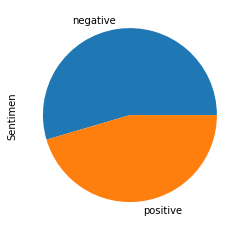

In [73]:
df['Sentimen'].value_counts().plot(kind='pie')

### Words distribution

In [74]:
df_explode = df['Text'].str.split().explode()
df_explode

0                  Jam
0                    8
0        alhamdulillah
1        Alhamdulillah
1                 naik
             ...      
11999         ngerjain
11999        pekerjaan
11999            rumah
11999              tuh
11999      yah!!!!!!!!
Name: Text, Length: 298519, dtype: object

In [75]:
df_explode.value_counts()[:20]

lu              7522
ya              2691
yg              2376
yang            2326
banget          2257
di              1908
dan             1782
ga              1619
aja             1558
gua             1536
anjing          1524
semangat        1469
aku             1456
bagus           1434
babi            1408
itu             1371
LU              1369
menyenangkan    1327
ini             1302
sama            1285
Name: Text, dtype: int64

In [76]:
df_explode.value_counts()[-20:]

Alhamdulillah,terima    1
perut,                  1
SCREENSHOTNYA           1
duha                    1
LRP,                    1
@haorits                1
muaythai                1
AURORAA                 1
cryin                   1
ufuk,                   1
netein                  1
sukaa.                  1
cangcut                 1
MENGECIL                1
sigo                    1
dimiliki                1
elips                   1
Ehekk                   1
PlayNow                 1
422                     1
Name: Text, dtype: int64

In [98]:
df_explode.value_counts().shape

(25960,)

In [78]:
texts = ' '.join(df["Text"])

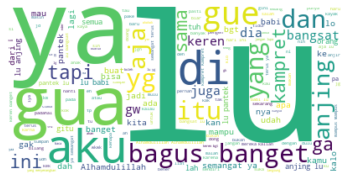

In [79]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(texts)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Dari pengataman diatas dapat terlihat bahwa banyak tanda baca ataupun kata-kata yang mempunyai akar kata yang sama namun dianggap kata yang berbeda (contoh: "yg" dan "yang"), ada ketidakkonsistenan penulisan huruf kapital sehingga ada kata yang sama namun dianggap berbeda. Selain itu, kata-kata yang mempunyai frekuensi tertinggi merupakan kata-kata yang bisa digolongkan sebagai stopword dan akan dicoba juga penggunaan stemming untuk mengatasi masalah tersebut.


### Data Cleaning

Dari permasalahan diatas akan dilakukan proses sebagai berikut:

* text_lower: mengubah semua semua huruf kapital ke dalam huruf kecil
* text_cleaning: menghilangkan semua karakter kecuali karakter alfabet
* text_stemming: mengubah suatu kata ke dalam bentuk akarnya, pada percobaan ini algoritma yang digunakan adalah algoritma stemming [Nazief-Andriani](https://)
* stopwords_removal: menghilangkan semua kata yang terdapat di dalam stopwords, pada percobaan ini daftar stopword yang digunakan adalah daftar stopword hasil penelitian [(Tala et al., 2003)](https://pdfs.semanticscholar.org/8ed9/c7d54fd3f0b1ce3815b2eca82147b771ca8f.pdf)
* text_norm: mengubah kata singkatan menjadi kata asalnya. Daftar singkatan ini didapat dari https://www.kaggle.com/tiobagas/datasetsentimen#data_latih.json



In [80]:
def text_lower(texts):
    return texts.lower()

def text_cleaning(texts):
    return ' '.join((re.sub(r'[^a-z]', ' ', texts)).split())

def text_stemming(texts):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(texts)

def stopwords_removal(texts):
    texts_token = texts.split()
    not_stopword = []
    for token in texts_token:
        if token not in stopwords:
            not_stopword.append(token)
    return ' '.join(not_stopword)

def text_norm(texts):
    words = texts.split()
    for i in range(len(words)):
        try:
            words[i] = normwords.loc[words[i]]['hasil']
        except:
            pass
    return ' '.join(words)

In [81]:
def load_normwords(file):
    return pd.read_csv(file, index_col=['singkat'])

def load_stopwords(file):
    return [line.rstrip('\n\r') for line in open(file)]

In [82]:
def preprocessing(texts):
    tx_lower = text_lower(texts)
    tx_clean = text_cleaning(tx_lower)
    tx_norm = text_norm(tx_clean)
    return tx_norm

In [84]:
global stopwords
global normwords

stopwords = load_stopwords("Model/stopword_list_TALA.txt")
normwords = load_normwords("Model/key_norm.csv")

Ditambahkan beberapa kata ke dalam daftar stopword dan menghilangkan beberapa kata disesuaikan dengan kebutuhan untuk proses analisis sentimen

In [85]:
stopwords.extend(['nya'])
stopwords.remove('tidak')
stopwords.remove('enggak')
stopwords.remove('lama')

In [86]:
df_norm = df['Text'].apply(preprocessing)

In [87]:
df_norm

0                                        jam alhamdulillah
1            alhamdulillah naik terus sekarang sudah lulus
2                                            alhamdulillah
3        alhamdulillah kenyang kupat tahu nya banyak ba...
4        ada pepatah greek mengatakan whom the gods lov...
                               ...                        
11995    hai bangsat bisa tidak kalau emang tidak ada n...
11996                            heh bangsat bener kamu ya
11997    ingin saya teriakin heh cowok babi sikut item ...
11998    si bangsat tau begitu kemarin kamu tidak usah ...
11999    buat kamu yang suka ngelawan ibuk kamu dirumah...
Name: Text, Length: 21993, dtype: object

In [88]:
df_norm.str.split().explode().value_counts()[:20]

kamu             13573
saya              7741
tidak             6158
yang              5161
ya                4441
banget            4232
anjing            2793
saja              2671
sudah             2471
semangat          2358
bagus             2261
sama              2166
di                2164
babi              2140
mampus            2110
bangsat           2106
alhamdulillah     2069
menyenangkan      2051
pantek            2049
ini               2042
Name: Text, dtype: int64

In [89]:
df_norm.str.split().explode().value_counts().shape

(30943,)

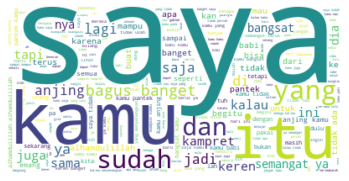

In [91]:
df_explode = df_norm.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_norm))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [92]:
df_stem = df_norm.apply(text_stemming)

In [93]:
df_stem

0                                        jam alhamdulillah
1            alhamdulillah naik terus sekarang sudah lulus
2                                            alhamdulillah
3        alhamdulillah kenyang kupat tahu nya banyak ba...
4        ada pepatah greek kata whom the gods love dies...
                               ...                        
11995    hai bangsat bisa tidak kalau emang tidak ada n...
11996                            heh bangsat bener kamu ya
11997    ingin saya teriakin heh cowok babi sikut item ...
11998    si bangsat tau begitu kemarin kamu tidak usah ...
11999    buat kamu yang suka ngelawan ibuk kamu rumah b...
Name: Text, Length: 21993, dtype: object

In [94]:
df_stem.str.split().explode().value_counts()[:20]

kamu             13578
saya              7742
tidak             6177
yang              5163
ya                4471
banget            4236
anjing            2811
saja              2672
sudah             2483
senang            2371
semangat          2371
bagus             2301
sama              2259
di                2164
babi              2146
bangsat           2113
mampus            2112
ini               2070
alhamdulillah     2069
itu               2064
Name: Text, dtype: int64

In [95]:
df_stem.str.split().explode().value_counts().shape

(25960,)

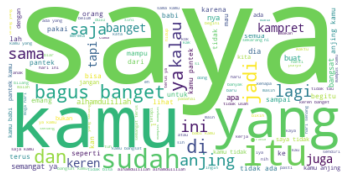

In [97]:
df_explode = df_stem.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_stem))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [99]:
df_stop = df_stem.apply(stopwords_removal)

In [100]:
df_stop

0                                        jam alhamdulillah
1                                      alhamdulillah lulus
2                                            alhamdulillah
3                       alhamdulillah kenyang kupat banget
4        pepatah greek whom the gods love dies young or...
                               ...                        
11995    hai bangsat tidak emang tidak niat baperin ana...
11996                                 heh bangsat bener ya
11997    teriakin heh cowok babi sikut item ketiak item...
11998    si bangsat tau kemarin tidak minjemin duit anjing
11999    suka ngelawan ibuk rumah bangsat banget minggu...
Name: Text, Length: 21993, dtype: object

In [101]:
df_stop.str.split().explode().value_counts()[:20]

tidak            6177
ya               4471
banget           4236
anjing           2811
senang           2371
semangat         2371
bagus            2301
babi             2146
bangsat          2113
mampus           2112
alhamdulillah    2069
pantek           2053
kampret          2030
keren            1987
orang            1730
emang            1052
tau               953
moga              938
sih               825
pakai             674
Name: Text, dtype: int64

In [102]:
df_stop.str.split().explode().value_counts().shape

(25682,)

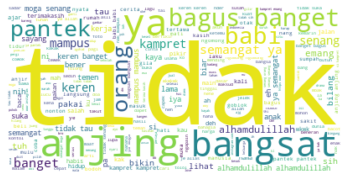

In [104]:
df_explode = df_stop.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_stop))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [105]:
df['Preprocessing'] = df_stop

In [106]:
df.Text.loc[0]

0                          Jam 8 alhamdulillah
0    Chenle itu lumba lumba bukan hiu kampret 
Name: Text, dtype: object

In [107]:
df.Preprocessing.loc[0]

0                 jam alhamdulillah
0    chenle lumba lumba hiu kampret
Name: Preprocessing, dtype: object

Dari kedua contoh diatas dapat terlihat bahwa setelah dilakukan *preprocessing* terdapat beberapa kata dan tanda baca yang hilang sehingga menghilangkan makna dari kalimat tersebut. Terlihat bahwa setelah penggunaan *preprocessing*, kalimat tersebut memiliki makna yang berbeda dibanding dengan kalimat awalnya, dikarenakan beberapa kata ada yang hilang, maupun berubah.

Dalam proses klasifikasi akan dibandingkan performansi dari penggunaan *preprocessing*.

### Words distribution for each class

#### Positive class

In [108]:
df_positive = df[(df['Sentimen'] == 'positive')]

In [109]:
df_positive.head()

,Text,keyword,Sentimen,Preprocessing
0,Jam 8 alhamdulillah,alhamdulillah,positive,jam alhamdulillah
1,Alhamdulillah naik terus skrg dah lulus,alhamdulillah,positive,alhamdulillah lulus
2,Alhamdulillah,alhamdulillah,positive,alhamdulillah
3,"Alhamdulillah, kenyang, kupat tahu nya banyak ...",alhamdulillah,positive,alhamdulillah kenyang kupat banget
4,"Ada pepatah Greek mengatakan, “whom the gods l...",alhamdulillah,positive,pepatah greek whom the gods love dies young or...


In [110]:
df_positive.shape

(9994, 4)

In [111]:
df_positive_explode = df_positive.Preprocessing.str.split().explode()

In [112]:
df_positive_explode.value_counts()[:20]

banget           3122
ya               3005
semangat         2339
tidak            2336
senang           2297
bagus            2223
alhamdulillah    2061
keren            1950
moga              879
orang             751
kak               478
lihat             345
i                 333
sih               330
tau               328
selamat           320
terimakasih       319
suka              314
a                 313
lupa              279
Name: Preprocessing, dtype: int64

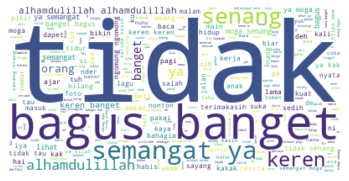

In [115]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_positive.Preprocessing))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative class

In [116]:
df_negative = df[(df['Sentimen'] == 'negative')]

In [117]:
df_negative.head()

,Text,keyword,Sentimen,Preprocessing
0,Chenle itu lumba lumba bukan hiu kampret,kampret,negative,chenle lumba lumba hiu kampret
1,@Fitokimiaa kampret dah,kampret,negative,fitokimiaa kampret
2,U kno kampret,kampret,negative,kno kampret
3,Ada woe kampret kali dibilang penyakit :/,kampret,negative,woe kampret kali bilang sakit
4,"Emang janji tinggal janji, ketika liat duit, A...",kampret,negative,emang janji tinggal janji lihat duit al qur an...


In [118]:
df_negative.shape

(11999, 4)

In [119]:
df_negative_explode = df_negative.Preprocessing.str.split().explode()

In [120]:
df_negative_explode.value_counts()[:20]

tidak      3841
anjing     2805
babi       2146
bangsat    2107
mampus     2107
pantek     2053
kampret    2029
ya         1466
banget     1114
orang       979
emang       775
tau         625
si          530
sih         495
pakai       433
bilang      426
suka        354
lihat       325
kau         323
tuh         323
Name: Preprocessing, dtype: int64

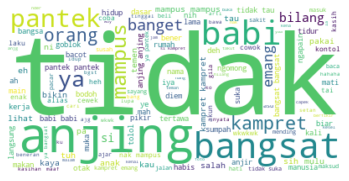

In [121]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_negative.Preprocessing))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Preparation

In [122]:
# convert class ['negative', 'positive'] into [0, 1]
y_train = np.array(list(df['Sentimen'].replace(['negative', 'positive'], [0, 1])))

In [123]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [124]:
num_words = 30000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_norm)

In [125]:
# Convert words into tokens
X_train_norm = tokenizer.texts_to_sequences(df_norm)

In [126]:
X_train_norm[0]

[166, 17]

In [127]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

sequence_to_text(X_train_norm[0])

['jam', 'alhamdulillah']

In [128]:
print('Maximum review length: {}'.format(len(max(X_train_norm, key=len))))
print('Minimum review length: {}'.format(len(min(X_train_norm, key=len))))

Maximum review length: 65
Minimum review length: 0


Dari hasil diatas terlihat bahwa panjang maksimum dari token dalam data latih adalah 83 token, lalu diberi *padding* untuk menyamakan dimensi dari setiap kalimat dalam data latih.

Maksimal panjang token diatur sebanyak 100 untuk mengantisipasi jika ada data yang memiliki token lebih 83 di data uji.

Pada percobaan ini saya menggunakan *pre-padding* atau memberi angka 0 di depan kalimat, hal tersebut dikarenakan jika menggunakan *post-padding* akan ada banyak angka 0 di akhir *sequence* yang menyebabkan proses klasifikasi tidak maksimal.

In [129]:
X_train_norm_pad = pad_sequences(X_train_norm, maxlen=100, padding='pre', truncating='pre')

In [132]:
X_train_norm_pad[100]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,    81,   269,
          26,   390,    17,  6317,  3367,     3, 12659, 12660, 12661,
        2564], dtype=int32)

## Classifier Construction

Dalam proses klasifikasi menggunakan metode Long Short Term Memory (LSTM) yang mempunyai 64 unit. Epoch yang digunakan adalah 10, dikarenakan setelah beberapa kali percobaan dilakukan, proses *training* sudah jenuh pada epoch tersebut.

In [133]:
def model_structure(max_token=100, embedding_size=256):
    model = Sequential()
    model.add(Embedding(input_dim=num_words,
                      output_dim=embedding_size,
                      input_length=max_token,
                      name='Embedding_layer'))
    model.add(LSTM(units=64, name='LSTM_layer'))
    model.add(Dense(1, activation='sigmoid', name='Output_layer'))
    model.compile(loss='mean_squared_error',
                optimizer=Adam(lr=1e-3),
                metrics=['accuracy'])
    return model

def model_summary(model):
    print(model.summary())

def model_fit(model, X, y, epoch=10):
    return model.fit(X, y, epochs=epoch)

In [134]:
def model_construction(X, y, num_words=7000, maxlen=100, embedding_size=256, epoch=10):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X)
    X_train = tokenizer.texts_to_sequences(X)
    X_train_pad = pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='pre')
    model = model_structure(max_token=maxlen, embedding_size=embedding_size)
    model_summary(model)
    model_fit(model, X_train_pad, y, epoch=epoch)
    return model, tokenizer

In [135]:
model_norm, tokenizer_norm = model_construction(df_norm, y_train, num_words=num_words)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          7680000   
_________________________________________________________________
LSTM_layer (LSTM)            (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 7,762,241
Trainable params: 7,762,241
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 21993 samples
Epoch 1/10
 1056/21993 [>.............................]

KeyboardInterrupt: 

In [0]:
with open('Model/tokenizer_norm.pickle', 'wb') as handle:
    pickle.dump(tokenizer_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_norm.save('Model/model_norm.h5')

In [103]:
model_stem, tokenizer_stem = model_construction(df_stem, y_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          1792000   
_________________________________________________________________
LSTM_layer_2 (LSTM)          (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 1,874,241
Trainable params: 1,874,241
Non-trainable params: 0
_________________________________________________________________
None
Train on 1780 samples
Epoch 1/10
1780/1780 [==============================] - 8s 4ms/sample - loss: 0.1780 - acc: 0.7287
Epoch 2/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0802 - acc: 0.9028
Epoch 3/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0370 - acc: 0.9562
Epoch 4/10
1780/1780 [============================

In [0]:
with open('Model/tokenizer_stem.pickle', 'wb') as handle:
    pickle.dump(tokenizer_stem, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_stem.save('Model/model_stem.h5')

In [105]:
model_stop, tokenizer_stop = model_construction(df_stop, y_train)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          1792000   
_________________________________________________________________
LSTM_layer_2 (LSTM)          (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 1,874,241
Trainable params: 1,874,241
Non-trainable params: 0
_________________________________________________________________
None
Train on 1780 samples
Epoch 1/10
1780/1780 [==============================] - 8s 4ms/sample - loss: 0.1820 - acc: 0.7331
Epoch 2/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0727 - acc: 0.9084
Epoch 3/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0339 - acc: 0.9596
Epoch 4/10
1780/1780 [============================

In [0]:
with open('Model/tokenizer_stop.pickle', 'wb') as handle:
    pickle.dump(tokenizer_stop, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_stop.save('Model/model_stop.h5')

## Model Evaluate

In [0]:
df_test = pd.read_csv('Dataset/test_data_restaurant.tsv', sep='\t', header=None)
df_test.rename(columns={0: 'Text', 1: 'Sentimen'}, inplace=True)

In [108]:
df_test.head()

,Text,Sentimen
0,"Tempatnya sih menarik, mudah dijangkau dari se...",negative
1,lokasi strategis penasaran karena daerah situ ...,negative
2,"Sesuai namanya, restoran ini unik dalam menyaj...",negative
3,Saya datang ketika petang dan hujan deras temp...,negative
4,"Kalao mau ke sana jangan pas malem sih, soalny...",negative


In [109]:
df_test.shape

(185, 2)

In [0]:
df_test_norm = df_test['Text'].apply(preprocessing)
df_test_stem = df_test_norm.apply(text_stemming)
df_test_stop = df_test_stem.apply(stopwords_removal)

In [0]:
y_test = np.array(list(df_test['Sentimen'].replace(['negative', 'positive'], [0, 1])))

In [0]:
def model_score(X, y, model, tokenizer, max_len=100):
    X_test = tokenizer.texts_to_sequences(X)
    X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
    return model.evaluate(X_test_pad, y, verbose=0)

def model_predict(X, y, model, tokenizer, max_len=100):
    X_test = tokenizer.texts_to_sequences(X)
    X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
    return model.predict_classes(X_test_pad)

### Model1 Evaluation

In [113]:
model_score(df_test_norm, y_test, model_norm, tokenizer_norm)[1]

0.8216216

In [0]:
y_pred_norm = model_predict(df_test_norm, y_test, model_norm, tokenizer_norm)

In [115]:
confusion_matrix(y_test, y_pred_norm)

array([[ 40,  25],
       [  8, 112]])

In [127]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_norm).ravel()
(tn, fp, fn, tp)

(40, 25, 8, 112)

### Model2 Evaluation

In [116]:
model_score(df_test_stem, y_test, model_stem, tokenizer_stem)[1]

0.81621623

In [0]:
y_pred_stem = model_predict(df_test_stem, y_test, model_stem, tokenizer_stem)

In [118]:
confusion_matrix(y_test, y_pred_stem)

array([[ 37,  28],
       [  6, 114]])

In [128]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stem).ravel()
(tn, fp, fn, tp)

(37, 28, 6, 114)

### Model3 Evaluation

In [119]:
model_score(df_test_stop, y_test, model_stop, tokenizer_stop)[1]

0.72432435

In [0]:
y_pred_stop = model_predict(df_test_stop, y_test, model_stop, tokenizer_stop)

In [121]:
confusion_matrix(y_test, y_pred_stop)

array([[ 32,  33],
       [ 18, 102]])

In [129]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stop).ravel()
(tn, fp, fn, tp)

(32, 33, 18, 102)

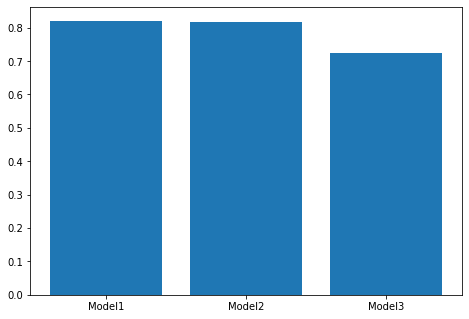

In [125]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
models = ['Model1', 'Model2', 'Model3']
scores = [model_score(df_test_norm, y_test, model_norm, tokenizer_norm)[1],
          model_score(df_test_stem, y_test, model_stem, tokenizer_stem)[1],
          model_score(df_test_stop, y_test, model_stop, tokenizer_stop)[1]]
ax.bar(models, scores)
plt.show()

## Conclusion

Dari percobaan yang telah dilakukan dapat disimpulkan bahwa model tanpa menggunakan *stemming* dan *stopword removal* menghasilkan hasil yang terbaik, yaitu akurasi sebesar 82,16%. Sementara model yang menggunakan *stemming* dan *stopword removal* mempunyai nilai akurasi terkecil, yaitu 72,43%. Hal ini terjadi karena banyaknya kata-kata yang hilang dikarenakan merupakan kata-kata yang terdapat di dalam daftar stopword. Selain itu, model yang digunakan dalam percobaan ini yaitu LSTM, bekerja dengan melihat pola dalam kalimat, berbeda dengan metode *machine learning* pada umumnya yang menghitung statistik antar kata, sehingga model1 dan model2 mendapatkan hasil yang lebih baik dari model3, walaupun model1 sedikit lebih baik dari model2, karena model2 beberapa kata memiliki perbedaan makna karena proses stemming.

Selain itu, di semua model mempunyai kasus false positif lebih banyak dari false negatif. Hal ini terjadi dikarenakan jumlah kelas *positive* di data latih jauh lebih besar dibandingkan kelas *negative*, sehingga menyebabkan probabilitas model untuk mengklasifikasikan suatu kalimat ke dalam kelas *positive* jauh lebih besar dari kelas *negative*.